In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
from scipy.stats import norm
import scipy.integrate as integrate

import gym
from gym import spaces

import random
import itertools as it
from joblib import Parallel, delayed
from toolz import memoize
from contracts import contract
from collections import namedtuple, defaultdict, deque, Counter

import warnings
warnings.filterwarnings("ignore", 
                        message="The objective has been evaluated at this point before.")

from agents import Agent
from oldmouselab import OldMouselabEnv
from policies import FixedPlanPolicy, LiederPolicy
from evaluation import *
from distributions import cmax, smax, sample, expectation, Normal, PointMass, SampleDist, TruncatedNormal, Categorical

In [2]:
import ipyparallel as ipp 
rc = ipp.Client(profile='default', cluster_id='')
ipp.register_joblib_backend()

# Mouselab Environment

In [5]:
gambles = 4
attributes = [0.24,0.74,0.01,0.01]
reward = Normal(2,1)
cost=0.03
env = OldMouselabEnv(gambles, attributes, reward)

In [6]:
attributes = 4
env = OldMouselabEnv(gambles, attributes, reward, cost, randomness=0.1)

In [7]:
env.action_features(4)

array([-0.03 , -1.   ,  0.357,  0.896,  2.   ])

## Time features

In [8]:
import datetime

In [9]:
env.dist

array([  7.631e-07,   8.006e-11,   8.874e-01,   1.126e-01])

### VPI_all

In [10]:
a = datetime.datetime.now()
means = []
for i in range(100):
    means.append(env.vpi())
t = datetime.datetime.now() - a
print(np.mean(means))

0.920058062308


In [11]:
print(t)

0:00:01.584687


### VPI_all2

In [12]:
a = datetime.datetime.now()
means = []
for i in range(100):
    means.append(env.vpi2())
t = datetime.datetime.now() - a
print(np.mean(means))

0.920884276471


In [13]:
print(t)

0:00:01.507293


### VPI_action

In [14]:
a = datetime.datetime.now()
for i in range(100):
    env.vpi_action(2)
t = datetime.datetime.now() - a
print(t)

0:00:01.305996


### Myopic_VOI

In [15]:
a = datetime.datetime.now()
for i in range(100):
    env.myopic_voi(2)
t = datetime.datetime.now() - a
print(t)

0:00:01.370323


# Training

In [16]:
def hd_dist(attributes):
    dist = [1,]*attributes
    dist[0] = np.random.randint(85,97)
    for i in range(1,attributes-1):
        dist[i] += np.random.randint(0,100-np.sum(dist))
    dist[-1] += 100-np.sum(dist)
    dist = np.around(np.array(dist)/100,decimals=2)
    np.random.shuffle(dist)
    return dist

In [17]:
for _ in range(1000):
    if np.max(hd_dist(4)) < 0.85:
        print('goshdarn')
        break

In [18]:
def ld_dist(attributes):
    constrain = True
    while constrain:
        dist = [np.random.randint(10,50) for _ in range(attributes)]
        dist = np.around(np.array(dist)/sum(dist),decimals=2)
        constrain = np.min(dist) <= 0.10 or np.max(dist) >= 0.40
    np.random.shuffle(dist)
    return dist

In [19]:
for _ in range(1000):
    dist = ld_dist(4)
    if np.min(dist) <= 0.10 or np.max(dist) >= 0.40:
        print('goshdarn')
        break

## High Stakes 3 cents

In [13]:
gambles = 7
attributes = 4
# reward = Normal(0,1)
# max_obs=30
high_stakes = Normal((9.99+0.01)/2, 0.3*(9.99-0.01))
low_stakes = Normal((0.25+0.01)/2, 0.3*(0.25-0.01))
reward = high_stakes
cost=.03

#set to 20 for sanity check
n_train = 20
n_test = 20

train_envs_hd = [OldMouselabEnv(gambles, hd_dist(attributes), reward, cost) for _ in range(n_train)]
train_envs_ld = [OldMouselabEnv(gambles, ld_dist(attributes), reward, cost) for _ in range(n_train)]
train_envs = train_envs_hd+train_envs_ld 

test_envs_hd =  [OldMouselabEnv(gambles, hd_dist(attributes), reward, cost) for _ in range(n_train)]
test_envs_ld = [OldMouselabEnv(gambles, ld_dist(attributes), reward, cost) for _ in range(n_train)]
test_envs = test_envs_hd+test_envs_ld 

term_action = train_envs[0].term_action

In [23]:
bo_pol_theta = np.load('data/high_stakes_3cents.npy')
bo_pol = LiederPolicy(list(bo_pol_theta))

In [24]:
a = datetime.datetime.now()
# bop2 = bo_policy(train_envs, max_cost=max_obs, n_jobs=20, n_calls=20, x0=[1., 1., 0., 0.])
bo_pol, result = bo_policy(train_envs, max_cost=30, n_jobs=20, n_calls=20, x0=list(bo_pol.theta[:-1]),
                           verbose=1, normalize_voi=True, return_result=True)
t = datetime.datetime.now() - a
print(t)

[ 2.978  0.396  0.079  0.524  1.   ] -> 7.039 in 33 sec
[ 18.192   0.331   0.337   0.332   1.   ] -> 6.899 in 21 sec
[ 19.083   0.52    0.403   0.077   1.   ] -> 6.453 in 16 sec
[ 8.907  0.27   0.459  0.271  1.   ] -> 7.112 in 29 sec
[ 12.391   0.459   0.185   0.356   1.   ] -> 7.077 in 22 sec
[ 11.679   0.486   0.071   0.442   1.   ] -> 7.142 in 25 sec
[ 14.735   0.4     0.26    0.339   1.   ] -> 7.031 in 20 sec
[ 21.898   0.31    0.286   0.404   1.   ] -> 6.811 in 20 sec
[ 4.071  0.339  0.133  0.528  1.   ] -> 7.031 in 31 sec
[ 7.28   0.222  0.532  0.246  1.   ] -> 7.005 in 26 sec
[ 7.447  0.222  0.519  0.259  1.   ] -> 7.046 in 27 sec
[ 30.      0.378   0.245   0.378   1.   ] -> 6.553 in 15 sec
[ 9.827  0.     0.5    0.5    1.   ] -> 6.925 in 35 sec
[ 1.   0.5  0.5  0.   1. ] -> 7.077 in 33 sec
[ 8.934  0.588  0.     0.412  1.   ] -> 7.139 in 27 sec
[ 6.539  0.682  0.     0.318  1.   ] -> 7.07 in 29 sec
[ 11.13    0.547   0.      0.453   1.   ] -> 7.031 in 28 sec
[ 1.     0.788  0. 

/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


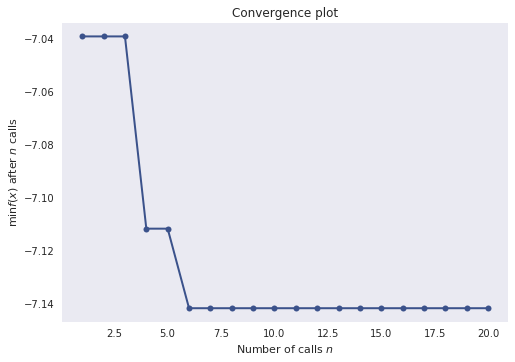

In [25]:
from skopt.plots import plot_convergence, plot_evaluations, plot_objective
plot_convergence(result)

In [26]:
bo_pol.theta

array([ 11.679,   0.486,   0.071,   0.442,   1.   ])

In [219]:
# np.save('high_stakes_3cents',bo_pol.theta)

In [27]:
a = datetime.datetime.now()
bo_utils = get_util(bo_pol, test_envs, parallel=Parallel(n_jobs=20),return_mean=False)
t = datetime.datetime.now() - a

In [28]:
np.mean(bo_utils)

7.1193556381263559

In [29]:
mg_pol = LiederPolicy([1, 1, 0, 0, 1])
a = datetime.datetime.now()
mg_utils = get_util(mg_pol, test_envs, parallel=Parallel(n_jobs=20),return_mean=False)
t = datetime.datetime.now() - a

In [30]:
np.mean(mg_utils)

7.2164397985038464

In [31]:
from scipy.stats import ttest_ind
ttest_ind(bo_utils,mg_utils)

Ttest_indResult(statistic=-0.34340012753570187, pvalue=0.73222134529588634)

In [32]:
from scipy.stats import ttest_rel
ttest_rel(bo_utils,mg_utils)

Ttest_relResult(statistic=-1.2061004963574689, pvalue=0.23504481889857098)

In [33]:
no_pol = FixedPlanPolicy([term_action])
a = datetime.datetime.now()
no_utils = get_util(no_pol, test_envs, parallel=Parallel(n_jobs=20),return_mean=False)
t = datetime.datetime.now() - a

In [34]:
np.mean(no_utils)

5.0

In [35]:
fo_pol = FixedPlanPolicy(range(term_action+1))
a = datetime.datetime.now()
fo_utils = get_util(fo_pol, test_envs, parallel=Parallel(n_jobs=20),return_mean=False)
t = datetime.datetime.now() - a

In [36]:
np.mean(fo_utils)

6.75839878191419

In [37]:
utils = [bo_utils,mg_utils,no_utils,fo_utils]
policies = ['bo','metagreedy','none','full-obs']
d_list = []
for u,p in zip(utils,policies):
    for result in u:
        d_list.append({'util':result,'stakes':'high','cost':0.03,'policy':p})

In [38]:
df = pd.DataFrame(d_list)
df

,cost,policy,stakes,util
0,0.03,bo,high,7.292699
1,0.03,bo,high,7.912315
2,0.03,bo,high,6.097723
3,0.03,bo,high,7.375388
4,0.03,bo,high,6.781878
5,0.03,bo,high,11.511568
6,0.03,bo,high,5.812373
7,0.03,bo,high,6.716564
8,0.03,bo,high,7.166972
9,0.03,bo,high,6.875504


In [39]:
df[df['policy'] == 'metagreedy'].util.mean()

7.216439798503847

In [234]:
# df.to_hdf('high_stakes_3cents_results','results')

In [42]:
df2 = pd.read_hdf('data/high_stakes_3cents_results','results')

In [43]:
df2[df2['policy']=='metagreedy'].util.mean()

7.4295954581247585

## High Stakes 0.5 cents

In [42]:
gambles = 7
attributes = 4
# reward = Normal(0,1)
# max_obs=30
high_stakes = Normal((9.99+0.01)/2, 0.3*(9.99-0.01))
low_stakes = Normal((0.25+0.01)/2, 0.3*(0.25-0.01))
reward = high_stakes
cost=.005

#set to 20 for sanity check
n_train = 250
n_test = 250

train_envs_hd = [OldMouselabEnv(gambles, hd_dist(attributes), reward, cost) for _ in range(n_train)]
train_envs_ld = [OldMouselabEnv(gambles, ld_dist(attributes), reward, cost) for _ in range(n_train)]
train_envs = train_envs_hd+train_envs_ld 

test_envs_hd =  [OldMouselabEnv(gambles, hd_dist(attributes), reward, cost) for _ in range(n_train)]
test_envs_ld = [OldMouselabEnv(gambles, ld_dist(attributes), reward, cost) for _ in range(n_train)]
test_envs = test_envs_hd+test_envs_ld 

term_action = train_envs[0].term_action

In [54]:
a = datetime.datetime.now()
# bop2 = bo_policy(train_envs, max_cost=max_obs, n_jobs=20, n_calls=20, x0=[1., 1., 0., 0.])
bo_pol, result = bo_policy(train_envs, max_cost=30, n_jobs=50, n_calls=20, x0=[1., 1., 0., 0.],
                           verbose=1, normalize_voi=True, return_result=True)
t = datetime.datetime.now() - a
print(t)

[ 1.  1.  0.  0.  1.] -> 7.733 in 251 sec
[ 18.192   0.331   0.337   0.332   1.   ] -> 7.684 in 235 sec
[ 19.083   0.52    0.403   0.077   1.   ] -> 7.615 in 215 sec
[ 8.907  0.27   0.459  0.271  1.   ] -> 7.745 in 254 sec
[ 12.391   0.459   0.185   0.356   1.   ] -> 7.736 in 245 sec
[ 11.679   0.486   0.071   0.442   1.   ] -> 7.73 in 256 sec
[ 14.735   0.4     0.26    0.339   1.   ] -> 7.719 in 245 sec
[ 21.898   0.31    0.286   0.404   1.   ] -> 7.691 in 237 sec
[ 4.071  0.339  0.133  0.528  1.   ] -> 7.756 in 276 sec
[ 7.28   0.222  0.532  0.246  1.   ] -> 7.741 in 255 sec
[ 7.447  0.222  0.519  0.259  1.   ] -> 7.743 in 252 sec
[ 1.     0.563  0.     0.437  1.   ] -> 7.761 in 295 sec
[ 5.586  0.     0.     1.     1.   ] -> 7.687 in 402 sec
[ 1.     0.333  0.333  0.333  1.   ] -> 7.756 in 287 sec
[ 1.439  0.432  0.227  0.341  1.   ] -> 7.77 in 283 sec
[ 1.     0.333  0.333  0.333  1.   ] -> 7.759 in 290 sec
[ 30.    0.    0.5   0.5   1. ] -> 7.616 in 330 sec
[ 1.  0.  1.  0.  1.] -

/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


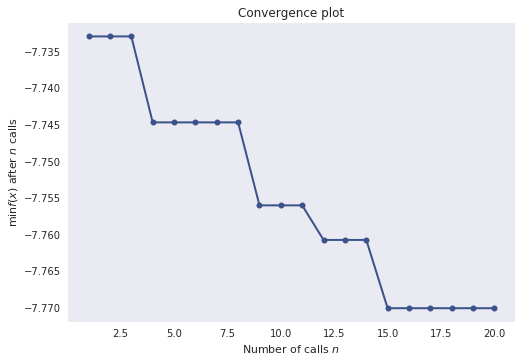

In [55]:
from skopt.plots import plot_convergence, plot_evaluations, plot_objective
plot_convergence(result)

In [56]:
bo_pol.theta

array([ 1.439,  0.432,  0.227,  0.341,  1.   ])

In [57]:
np.save('high_stakes_0.5cents',bo_pol.theta)

In [58]:
a = datetime.datetime.now()
bo_utils = get_util(bo_pol, test_envs, parallel=Parallel(n_jobs=20),return_mean=False)
t = datetime.datetime.now() - a

In [59]:
np.mean(bo_utils)

7.7433763740509374

In [60]:
mg_pol = LiederPolicy([1, 1, 0, 0, 1])
a = datetime.datetime.now()
mg_utils = get_util(mg_pol, test_envs, parallel=Parallel(n_jobs=20),return_mean=False)
t = datetime.datetime.now() - a

In [61]:
np.mean(mg_utils)

7.725590252403717

In [62]:
from scipy.stats import ttest_ind
ttest_ind(bo_utils,mg_utils)

Ttest_indResult(statistic=0.17214834270603308, pvalue=0.86335580959839286)

In [63]:
from scipy.stats import ttest_rel
ttest_rel(bo_utils,mg_utils)

Ttest_relResult(statistic=1.1993257440687035, pvalue=0.23097048047022117)

In [64]:
no_pol = FixedPlanPolicy([term_action])
a = datetime.datetime.now()
no_utils = get_util(no_pol, test_envs, parallel=Parallel(n_jobs=20),return_mean=False)
t = datetime.datetime.now() - a

In [65]:
np.mean(no_utils)

5.0

In [66]:
fo_pol = FixedPlanPolicy(range(term_action+1))
a = datetime.datetime.now()
fo_utils = get_util(fo_pol, test_envs, parallel=Parallel(n_jobs=20),return_mean=False)
t = datetime.datetime.now() - a

In [67]:
np.mean(fo_utils)

7.6749280800196669

In [73]:
utils = [bo_utils,mg_utils,no_utils,fo_utils]
policies = ['bo','metagreedy','none','full-obs']
d_list = []
for u,p in zip(utils,policies):
    for result in u:
        d_list.append({'util':result,'stakes':'high','cost':cost,'policy':p})

In [74]:
df = pd.DataFrame(d_list)
df

,cost,policy,stakes,util
0,0.005,bo,high,6.852340
1,0.005,bo,high,5.454727
2,0.005,bo,high,10.352320
3,0.005,bo,high,7.261624
4,0.005,bo,high,13.252235
5,0.005,bo,high,8.644943
6,0.005,bo,high,10.433831
7,0.005,bo,high,6.377642
8,0.005,bo,high,9.270687
9,0.005,bo,high,7.817763


In [75]:
df[df['policy'] == 'metagreedy'].util.mean()

7.72559025240373

In [76]:
df.to_hdf('high_stakes_0.5cents_results','results')

In [79]:
df2 = pd.read_hdf('data/high_stakes_3cents_results','results')

In [80]:
df2[df2['policy']=='metagreedy'].util.mean()

7.4295954581247585

## Low Stakes 3 cents

In [83]:
gambles = 7
attributes = 4
# reward = Normal(0,1)
# max_obs=30
high_stakes = Normal((9.99+0.01)/2, 0.3*(9.99-0.01))
low_stakes = Normal((0.25+0.01)/2, 0.3*(0.25-0.01))
reward = low_stakes
cost=.03

#set to 20 for sanity check
n_train = 250
n_test = 250

train_envs_hd = [OldMouselabEnv(gambles, hd_dist(attributes), reward, cost) for _ in range(n_train)]
train_envs_ld = [OldMouselabEnv(gambles, ld_dist(attributes), reward, cost) for _ in range(n_train)]
train_envs = train_envs_hd+train_envs_ld 

test_envs_hd =  [OldMouselabEnv(gambles, hd_dist(attributes), reward, cost) for _ in range(n_train)]
test_envs_ld = [OldMouselabEnv(gambles, ld_dist(attributes), reward, cost) for _ in range(n_train)]
test_envs = test_envs_hd+test_envs_ld 

term_action = train_envs[0].term_action

In [84]:
a = datetime.datetime.now()
# bop2 = bo_policy(train_envs, max_cost=max_obs, n_jobs=20, n_calls=20, x0=[1., 1., 0., 0.])
bo_pol, result = bo_policy(train_envs, max_cost=30, n_jobs=50, n_calls=20, x0=[1., 1., 0., 0.],
                           verbose=1, normalize_voi=True, return_result=True)
t = datetime.datetime.now() - a
print(t)

[ 1.  1.  0.  0.  1.] -> 0.13 in 36 sec
[ 18.192   0.331   0.337   0.332   1.   ] -> 0.13 in 37 sec
[ 19.083   0.52    0.403   0.077   1.   ] -> 0.13 in 36 sec
[ 8.907  0.27   0.459  0.271  1.   ] -> 0.13 in 37 sec
[ 12.391   0.459   0.185   0.356   1.   ] -> 0.13 in 37 sec
[ 11.679   0.486   0.071   0.442   1.   ] -> 0.13 in 36 sec
[ 14.735   0.4     0.26    0.339   1.   ] -> 0.13 in 37 sec
[ 21.898   0.31    0.286   0.404   1.   ] -> 0.13 in 37 sec
[ 4.071  0.339  0.133  0.528  1.   ] -> 0.13 in 36 sec
[ 7.28   0.222  0.532  0.246  1.   ] -> 0.13 in 36 sec
[ 7.447  0.222  0.519  0.259  1.   ] -> 0.13 in 37 sec
[ 30.   0.   1.   0.   1.] -> 0.13 in 36 sec
[ 29.467   0.047   0.038   0.915   1.   ] -> 0.13 in 35 sec
[ 29.308   0.926   0.044   0.03    1.   ] -> 0.13 in 36 sec
[ 1.   0.   0.5  0.5  1. ] -> 0.004 in 216 sec
[ 30.    0.5   0.5   0.    1. ] -> 0.13 in 36 sec
[ 1.  1.  0.  0.  1.] -> 0.13 in 36 sec
[ 30.      0.325   0.675   0.      1.   ] -> 0.13 in 36 sec
[ 16.584   0.551  

/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


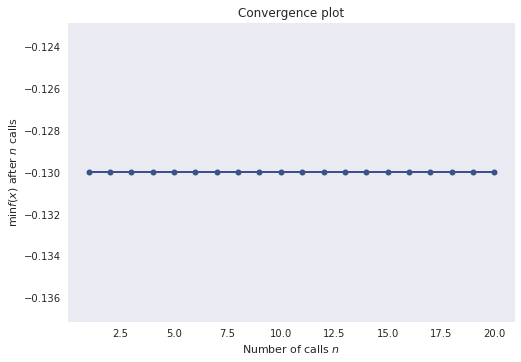

In [85]:
from skopt.plots import plot_convergence, plot_evaluations, plot_objective
plot_convergence(result)

In [86]:
bo_pol.theta

array([ 1.,  1.,  0.,  0.,  1.])

In [87]:
np.save('data/low_stakes_3cents',bo_pol.theta)

In [88]:
a = datetime.datetime.now()
bo_utils = get_util(bo_pol, test_envs, parallel=Parallel(n_jobs=20),return_mean=False)
t = datetime.datetime.now() - a

In [89]:
np.mean(bo_utils)

0.12999999999999998

In [90]:
mg_pol = LiederPolicy([1, 1, 0, 0, 1])
a = datetime.datetime.now()
mg_utils = get_util(mg_pol, test_envs, parallel=Parallel(n_jobs=20),return_mean=False)
t = datetime.datetime.now() - a

In [91]:
np.mean(mg_utils)

0.12999999999999998

In [92]:
from scipy.stats import ttest_ind
ttest_ind(bo_utils,mg_utils)

Ttest_indResult(statistic=0.0, pvalue=1.0)

In [93]:
from scipy.stats import ttest_rel
ttest_rel(bo_utils,mg_utils)

Ttest_relResult(statistic=nan, pvalue=nan)

In [94]:
no_pol = FixedPlanPolicy([term_action])
a = datetime.datetime.now()
no_utils = get_util(no_pol, test_envs, parallel=Parallel(n_jobs=20),return_mean=False)
t = datetime.datetime.now() - a

In [95]:
np.mean(no_utils)

0.12999999999999998

In [96]:
fo_pol = FixedPlanPolicy(range(term_action+1))
a = datetime.datetime.now()
fo_utils = get_util(fo_pol, test_envs, parallel=Parallel(n_jobs=20),return_mean=False)
t = datetime.datetime.now() - a

In [97]:
np.mean(fo_utils)

-0.63830073141754684

In [98]:
utils = [bo_utils,mg_utils,no_utils,fo_utils]
policies = ['bo','metagreedy','none','full-obs']
d_list = []
for u,p in zip(utils,policies):
    for result in u:
        d_list.append({'util':result,'stakes':'high','cost':cost,'policy':p})

In [99]:
df = pd.DataFrame(d_list)
df

,cost,policy,stakes,util
0,0.03,bo,high,0.130000
1,0.03,bo,high,0.130000
2,0.03,bo,high,0.130000
3,0.03,bo,high,0.130000
4,0.03,bo,high,0.130000
5,0.03,bo,high,0.130000
6,0.03,bo,high,0.130000
7,0.03,bo,high,0.130000
8,0.03,bo,high,0.130000
9,0.03,bo,high,0.130000


In [100]:
df[df['policy'] == 'metagreedy'].util.mean()

0.13000000000000103

In [101]:
df.to_hdf('low_stakes_3cents_results','results')

In [103]:
df2 = pd.read_hdf('low_stakes_3cents_results','results')

In [104]:
df2[df2['policy']=='metagreedy'].util.mean()

0.13000000000000103

## Low Stakes 0.5 cents

In [13]:
gambles = 7
attributes = 4
# reward = Normal(0,1)
# max_obs=30
high_stakes = Normal((9.99+0.01)/2, 0.3*(9.99-0.01))
low_stakes = Normal((0.25+0.01)/2, 0.3*(0.25-0.01))
reward = low_stakes
cost=.005

#set to 20 for sanity check
n_train = 250
n_test = 250

train_envs_hd = [OldMouselabEnv(gambles, hd_dist(attributes), reward, cost) for _ in range(n_train)]
train_envs_ld = [OldMouselabEnv(gambles, ld_dist(attributes), reward, cost) for _ in range(n_train)]
train_envs = train_envs_hd+train_envs_ld 

test_envs_hd =  [OldMouselabEnv(gambles, hd_dist(attributes), reward, cost) for _ in range(n_train)]
test_envs_ld = [OldMouselabEnv(gambles, ld_dist(attributes), reward, cost) for _ in range(n_train)]
test_envs = test_envs_hd+test_envs_ld 

term_action = train_envs[0].term_action

In [14]:
a = datetime.datetime.now()
# bop2 = bo_policy(train_envs, max_cost=max_obs, n_jobs=20, n_calls=20, x0=[1., 1., 0., 0.])
bo_pol, result = bo_policy(train_envs, max_cost=30, n_jobs=50, n_calls=20, x0=[1., 1., 0., 0.],
                           verbose=1, normalize_voi=True, return_result=True)
t = datetime.datetime.now() - a
print(t)

[ 1.  1.  0.  0.  1.] -> 0.165 in 138 sec
[ 18.192   0.331   0.337   0.332   1.   ] -> 0.13 in 34 sec
[ 19.083   0.52    0.403   0.077   1.   ] -> 0.13 in 35 sec
[ 8.907  0.27   0.459  0.271  1.   ] -> 0.134 in 40 sec
[ 12.391   0.459   0.185   0.356   1.   ] -> 0.13 in 34 sec
[ 11.679   0.486   0.071   0.442   1.   ] -> 0.13 in 34 sec
[ 14.735   0.4     0.26    0.339   1.   ] -> 0.13 in 34 sec
[ 21.898   0.31    0.286   0.404   1.   ] -> 0.13 in 34 sec
[ 4.071  0.339  0.133  0.528  1.   ] -> 0.164 in 129 sec
[ 7.28   0.222  0.532  0.246  1.   ] -> 0.15 in 65 sec
[ 7.447  0.222  0.519  0.259  1.   ] -> 0.15 in 65 sec
[ 30.   0.   0.   0.   1.] -> 0.13 in 34 sec
[ 1.   0.   0.5  0.5  1. ] -> 0.128 in 318 sec
[ 1.  1.  0.  0.  1.] -> 0.165 in 140 sec
[ 1.  1.  0.  0.  1.] -> 0.165 in 138 sec
[ 1.049  0.859  0.026  0.116  1.   ] -> 0.164 in 163 sec
[ 30.    0.5   0.5   0.    1. ] -> 0.13 in 34 sec
[ 1.   0.5  0.5  0.   1. ] -> 0.164 in 153 sec
[ 3.702  0.5    0.5    0.     1.   ] -> 0.155

In [44]:
# bo_pol_theta = np.load('low_stakes_0.5cents-2.npy')
# bo_pol = LiederPolicy(list(bo_pol_theta))

/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


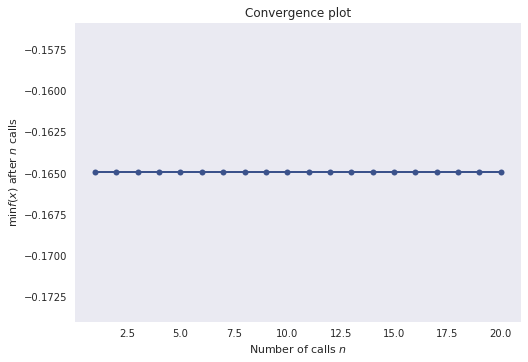

In [15]:
from skopt.plots import plot_convergence, plot_evaluations, plot_objective
plot_convergence(result)

In [16]:
bo_pol.theta

array([ 1.,  1.,  0.,  0.,  1.])

In [17]:
np.save('low_stakes_0.5cents-2',bo_pol.theta)

In [18]:
a = datetime.datetime.now()
bo_utils = get_util(bo_pol, test_envs, parallel=Parallel(n_jobs=20),return_mean=False)
t = datetime.datetime.now() - a

In [19]:
np.mean(bo_utils)

0.16670667750492293

In [20]:
mg_pol = LiederPolicy([1, 1, 0, 0, 1])
a = datetime.datetime.now()
mg_utils = get_util(mg_pol, test_envs, parallel=Parallel(n_jobs=20),return_mean=False)
t = datetime.datetime.now() - a

In [21]:
np.mean(mg_utils)

0.16670667750492293

In [22]:
from scipy.stats import ttest_ind
ttest_ind(bo_utils,mg_utils)

Ttest_indResult(statistic=0.0, pvalue=1.0)

In [23]:
from scipy.stats import ttest_rel
ttest_rel(bo_utils,mg_utils)

Ttest_relResult(statistic=nan, pvalue=nan)

In [24]:
no_pol = FixedPlanPolicy([term_action])
a = datetime.datetime.now()
no_utils = get_util(no_pol, test_envs, parallel=Parallel(n_jobs=20),return_mean=False)
t = datetime.datetime.now() - a

In [25]:
np.mean(no_utils)

0.13

In [26]:
fo_pol = FixedPlanPolicy(range(term_action+1))
a = datetime.datetime.now()
fo_utils = get_util(fo_pol, test_envs, parallel=Parallel(n_jobs=20),return_mean=False)
t = datetime.datetime.now() - a

In [27]:
np.mean(fo_utils)

0.059715955139078791

In [28]:
utils = [bo_utils,mg_utils,no_utils,fo_utils]
policies = ['bo','metagreedy','none','full-obs']
d_list = []
for u,p in zip(utils,policies):
    for result in u:
        d_list.append({'util':result,'stakes':'high','cost':cost,'policy':p})

In [29]:
df = pd.DataFrame(d_list)
df

,cost,policy,stakes,util
0,0.005,bo,high,0.150445
1,0.005,bo,high,0.135086
2,0.005,bo,high,0.235951
3,0.005,bo,high,0.145383
4,0.005,bo,high,0.260053
5,0.005,bo,high,0.204422
6,0.005,bo,high,0.223172
7,0.005,bo,high,0.183239
8,0.005,bo,high,0.200393
9,0.005,bo,high,0.205963


In [30]:
df[df['policy'] == 'metagreedy'].util.mean()

0.16670667750492293

In [31]:
df.to_hdf('data/low_stakes_0.5cents_results-2','results')

In [32]:
df2 = pd.read_hdf('data/low_stakes_0.5cents_results-2','results')

In [33]:
df2[df2['policy']=='metagreedy'].util.mean()

0.16670667750492293

## High Stakes 1 cents

In [45]:
gambles = 7
attributes = 4
# reward = Normal(0,1)
# max_obs=30
high_stakes = Normal((9.99+0.01)/2, 0.3*(9.99-0.01))
low_stakes = Normal((0.25+0.01)/2, 0.3*(0.25-0.01))
reward = high_stakes
cost=.01

#set to 20 for sanity check
n_train = 250
n_test = 250

train_envs_hd = [OldMouselabEnv(gambles, hd_dist(attributes), reward, cost) for _ in range(n_train)]
train_envs_ld = [OldMouselabEnv(gambles, ld_dist(attributes), reward, cost) for _ in range(n_train)]
train_envs = train_envs_hd+train_envs_ld 

test_envs_hd =  [OldMouselabEnv(gambles, hd_dist(attributes), reward, cost) for _ in range(n_train)]
test_envs_ld = [OldMouselabEnv(gambles, ld_dist(attributes), reward, cost) for _ in range(n_train)]
test_envs = test_envs_hd+test_envs_ld 

term_action = train_envs[0].term_action

In [46]:
for env in train_envs_ld:
    dist = env.dist
    if np.min(dist) <= 0.10 or np.max(dist) >= 0.40:
        print('goshdarn')
        break

In [47]:
a = datetime.datetime.now()
# bop2 = bo_policy(train_envs, max_cost=max_obs, n_jobs=20, n_calls=20, x0=[1., 1., 0., 0.])
bo_pol, result = bo_policy(train_envs, max_cost=30, n_jobs=100, n_calls=20, x0=[1., 1., 0., 0.],
                           verbose=1, normalize_voi=True, return_result=True)
t = datetime.datetime.now() - a
print(t)

[ 1.  1.  0.  0.  1.] -> 7.709 in 185 sec
[ 18.192   0.331   0.337   0.332   1.   ] -> 7.646 in 163 sec
[ 19.083   0.52    0.403   0.077   1.   ] -> 7.477 in 126 sec
[ 8.907  0.27   0.459  0.271  1.   ] -> 7.699 in 186 sec
[ 12.391   0.459   0.185   0.356   1.   ] -> 7.682 in 172 sec
[ 11.679   0.486   0.071   0.442   1.   ] -> 7.681 in 181 sec
[ 14.735   0.4     0.26    0.339   1.   ] -> 7.653 in 172 sec
[ 21.898   0.31    0.286   0.404   1.   ] -> 7.633 in 156 sec
[ 4.071  0.339  0.133  0.528  1.   ] -> 7.721 in 207 sec
[ 7.28   0.222  0.532  0.246  1.   ] -> 7.732 in 184 sec
[ 7.447  0.222  0.519  0.259  1.   ] -> 7.714 in 188 sec
[ 30.      0.35    0.247   0.403   1.   ] -> 7.515 in 143 sec
[ 5.284  0.     0.     1.     1.   ] -> 7.591 in 315 sec
[ 1.     0.333  0.333  0.333  1.   ] -> 7.711 in 217 sec
[ 1.   0.   0.5  0.5  1. ] -> 7.646 in 287 sec
[ 6.083  0.471  0.057  0.471  1.   ] -> 7.702 in 195 sec
[ 1.     0.405  0.405  0.19   1.   ] -> 7.732 in 209 sec
[ 1.     0.406  0.395

In [48]:
# bo_pol_theta = np.load('low_stakes_0.5cents-2.npy')
# bo_pol = LiederPolicy(list(bo_pol_theta))

/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


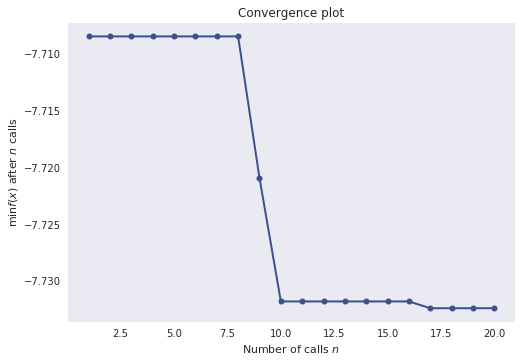

In [49]:
from skopt.plots import plot_convergence, plot_evaluations, plot_objective
plot_convergence(result)

In [50]:
bo_pol.theta

array([ 1.   ,  0.405,  0.405,  0.19 ,  1.   ])

In [51]:
np.save('high_stakes_1cents',bo_pol.theta)

In [52]:
a = datetime.datetime.now()
bo_utils = get_util(bo_pol, test_envs, parallel=Parallel(n_jobs=20),return_mean=False)
t = datetime.datetime.now() - a

In [53]:
np.mean(bo_utils)

7.8085663400437451

In [54]:
mg_pol = LiederPolicy([1, 1, 0, 0, 1])
a = datetime.datetime.now()
mg_utils = get_util(mg_pol, test_envs, parallel=Parallel(n_jobs=20),return_mean=False)
t = datetime.datetime.now() - a

In [55]:
np.mean(mg_utils)

7.7664932456538951

In [56]:
from scipy.stats import ttest_ind
ttest_ind(bo_utils,mg_utils)

Ttest_indResult(statistic=0.39723852701792428, pvalue=0.691276512879337)

In [57]:
from scipy.stats import ttest_rel
ttest_rel(bo_utils,mg_utils)

Ttest_relResult(statistic=2.2764069436231078, pvalue=0.023244397389127178)

In [58]:
no_pol = FixedPlanPolicy([term_action])
a = datetime.datetime.now()
no_utils = get_util(no_pol, test_envs, parallel=Parallel(n_jobs=20),return_mean=False)
t = datetime.datetime.now() - a

In [59]:
np.mean(no_utils)

5.0

In [60]:
fo_pol = FixedPlanPolicy(range(term_action+1))
a = datetime.datetime.now()
fo_utils = get_util(fo_pol, test_envs, parallel=Parallel(n_jobs=20),return_mean=False)
t = datetime.datetime.now() - a

In [61]:
np.mean(fo_utils)

7.6566241882291832

In [62]:
utils = [bo_utils,mg_utils,no_utils,fo_utils]
policies = ['bo','metagreedy','none','full-obs']
d_list = []
for u,p in zip(utils,policies):
    for result in u:
        d_list.append({'util':result,'stakes':'high','cost':cost,'policy':p})

In [63]:
df = pd.DataFrame(d_list)
df

,cost,policy,stakes,util
0,0.01,bo,high,8.523589
1,0.01,bo,high,10.535424
2,0.01,bo,high,7.192236
3,0.01,bo,high,12.517467
4,0.01,bo,high,8.959688
5,0.01,bo,high,7.938985
6,0.01,bo,high,6.509942
7,0.01,bo,high,9.538746
8,0.01,bo,high,4.557424
9,0.01,bo,high,8.733981


In [64]:
df[df['policy'] == 'metagreedy'].util.mean()

7.766493245653884

In [65]:
df.to_hdf('data/high_stakes_1cents_results','results')

In [66]:
df2 = pd.read_hdf('data/high_stakes_1cents_results','results')

In [67]:
df2[df2['policy']=='metagreedy'].util.mean()

7.766493245653884

## Low Stakes 1 cents

In [69]:
gambles = 7
attributes = 4
# reward = Normal(0,1)
# max_obs=30
high_stakes = TruncatedNormal((9.99+0.01)/2, 0.3*(9.99-0.01),0.01,9.99)
low_stakes = TruncatedNormal((0.25+0.01)/2, 0.3*(0.25-0.01),0.01,0.25)
reward = low_stakes
cost=.01

#set to 20 for sanity check
n_train = 250
n_test = 250

train_envs_hd = [OldMouselabEnv(gambles, hd_dist(attributes), reward, cost) for _ in range(n_train)]
train_envs_ld = [OldMouselabEnv(gambles, ld_dist(attributes), reward, cost) for _ in range(n_train)]
train_envs = train_envs_hd+train_envs_ld 

test_envs_hd =  [OldMouselabEnv(gambles, hd_dist(attributes), reward, cost) for _ in range(n_train)]
test_envs_ld = [OldMouselabEnv(gambles, ld_dist(attributes), reward, cost) for _ in range(n_train)]
test_envs = test_envs_hd+test_envs_ld 

term_action = train_envs[0].term_action

In [70]:
for env in train_envs_ld:
    dist = env.dist
    if np.min(dist) <= 0.10 or np.max(dist) >= 0.40:
        print('goshdarn')
        break

In [71]:
a = datetime.datetime.now()
# bop2 = bo_policy(train_envs, max_cost=max_obs, n_jobs=20, n_calls=20, x0=[1., 1., 0., 0.])
bo_pol, result = bo_policy(train_envs, max_cost=30, n_jobs=100, n_calls=30, x0=[1., 1., 0., 0.],
                           verbose=1, normalize_voi=True, return_result=True)
t = datetime.datetime.now() - a
print(t)

[ 1.  1.  0.  0.  1.] -> 0.142 in 114 sec
[ 18.192   0.331   0.337   0.332   1.   ] -> 0.13 in 39 sec
[ 19.083   0.52    0.403   0.077   1.   ] -> 0.13 in 39 sec
[ 8.907  0.27   0.459  0.271  1.   ] -> 0.13 in 39 sec
[ 12.391   0.459   0.185   0.356   1.   ] -> 0.13 in 38 sec
[ 11.679   0.486   0.071   0.442   1.   ] -> 0.13 in 39 sec
[ 14.735   0.4     0.26    0.339   1.   ] -> 0.13 in 39 sec
[ 21.898   0.31    0.286   0.404   1.   ] -> 0.13 in 39 sec
[ 4.071  0.339  0.133  0.528  1.   ] -> 0.142 in 80 sec
[ 7.28   0.222  0.532  0.246  1.   ] -> 0.13 in 39 sec
[ 7.447  0.222  0.519  0.259  1.   ] -> 0.13 in 39 sec
[ 1.  0.  0.  1.  1.] -> -0.018 in 444 sec
[ 1.     0.382  0.     0.618  1.   ] -> 0.112 in 237 sec
[ 1.  0.  1.  0.  1.] -> 0.094 in 253 sec
[ 30.      0.435   0.565   0.      1.   ] -> 0.13 in 39 sec
[ 1.     0.735  0.098  0.167  1.   ] -> 0.134 in 161 sec
[ 30.   1.   0.   0.   1.] -> 0.13 in 38 sec
[ 30.      0.384   0.384   0.232   1.   ] -> 0.13 in 39 sec
[ 30.      0.

In [72]:
# bo_pol_theta = np.load('low_stakes_0.5cents-2.npy')
# bo_pol = LiederPolicy(list(bo_pol_theta))

/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


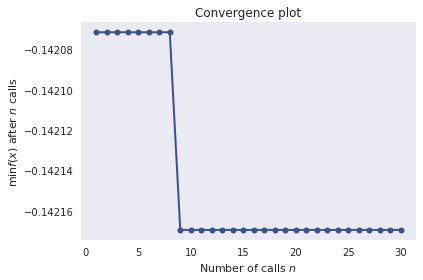

In [73]:
from skopt.plots import plot_convergence, plot_evaluations, plot_objective
plot_convergence(result)

In [74]:
bo_pol.theta

array([ 4.071,  0.339,  0.133,  0.528,  1.   ])

In [75]:
np.save('data/low_stakes_trunc_1cents-3',bo_pol.theta)

In [76]:
a = datetime.datetime.now()
bo_utils = get_util(bo_pol, test_envs, parallel=Parallel(n_jobs=100),return_mean=False)
t = datetime.datetime.now() - a

In [77]:
np.mean(bo_utils)

0.14225423596387204

In [78]:
mg_pol = LiederPolicy([1, 1, 0, 0, 1])
a = datetime.datetime.now()
mg_utils = get_util(mg_pol, test_envs, parallel=Parallel(n_jobs=100),return_mean=False)
t = datetime.datetime.now() - a

In [79]:
np.mean(mg_utils)

0.1434842975344911

In [80]:
from scipy.stats import ttest_ind
ttest_ind(bo_utils,mg_utils)

Ttest_indResult(statistic=-0.66628668969192983, pvalue=0.50538185705722816)

In [81]:
from scipy.stats import ttest_rel
ttest_rel(bo_utils,mg_utils)

Ttest_relResult(statistic=-1.1149110766755259, pvalue=0.26542519494949629)

In [82]:
no_pol = FixedPlanPolicy([term_action])
a = datetime.datetime.now()
no_utils = get_util(no_pol, test_envs, parallel=Parallel(n_jobs=100),return_mean=False)
t = datetime.datetime.now() - a

In [83]:
np.mean(no_utils)

0.12999999999999998

In [84]:
fo_pol = FixedPlanPolicy(range(term_action+1))
a = datetime.datetime.now()
fo_utils = get_util(fo_pol, test_envs, parallel=Parallel(n_jobs=100),return_mean=False)
t = datetime.datetime.now() - a

In [85]:
np.mean(fo_utils)

-0.095445833373423175

In [86]:
utils = [bo_utils,mg_utils,no_utils,fo_utils]
policies = ['bo','metagreedy','none','full-obs']
d_list = []
for u,p in zip(utils,policies):
    for result in u:
        d_list.append({'util':result,'stakes':'low','cost':cost,'policy':p})

In [87]:
df = pd.DataFrame(d_list)
df

,cost,policy,stakes,util
0,0.01,bo,low,0.216393
1,0.01,bo,low,0.152801
2,0.01,bo,low,0.191298
3,0.01,bo,low,0.220109
4,0.01,bo,low,0.207177
5,0.01,bo,low,0.126819
6,0.01,bo,low,0.141239
7,0.01,bo,low,0.198051
8,0.01,bo,low,0.198261
9,0.01,bo,low,0.111095


In [88]:
df[df['policy'] == 'metagreedy'].util.mean()

0.14348429753449138

In [89]:
df.to_hdf('data/low_stakes_trunc_1cents_results-3','results')

In [90]:
df2 = pd.read_hdf('data/low_stakes_trunc_1cents_results-3','results')

In [91]:
df2[df2['policy']=='metagreedy'].util.mean()

0.14348429753449138

## Validation

In [98]:
filenames = ['low_stakes_1cents-previous.npy', 'low_stakes_1cents.npy', 'low_stakes_trunc_1cents.npy', 'low_stakes_trunc_1cents-2.npy', 'low_stakes_trunc_1cents-3.npy']
low_stakes = TruncatedNormal((0.25+0.01)/2, 0.3*(0.25-0.01),0.01,0.25)
reward = low_stakes
test_envs_hd =  [OldMouselabEnv(gambles, hd_dist(attributes), reward, cost) for _ in range(n_train*2)]
test_envs_ld = [OldMouselabEnv(gambles, ld_dist(attributes), reward, cost) for _ in range(n_train*2)]

In [99]:
val_util = []
for polfil in filenames:
    bo_pol_theta = np.load('data/'+polfil)
    print(bo_pol_theta)
    bo_pol = LiederPolicy(list(bo_pol_theta))
    polutil_hd = get_util(bo_pol, test_envs_hd, parallel=Parallel(n_jobs=100),return_mean=False)
    print(np.mean(polutil_hd))
    polutil_ld = get_util(bo_pol, test_envs_ld, parallel=Parallel(n_jobs=100),return_mean=False)
    print(np.mean(polutil_ld))
    val_util.append(np.mean(polutil_hd))
    val_util.append(np.mean(polutil_ld))

[ 1.  1.  0.  0.  1.]
0.156659385296
0.128545236927
[ 1.124  0.623  0.318  0.059  1.   ]


/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


0.157069920912
0.123230046918
[ 1.328  0.828  0.167  0.005  1.   ]
0.158046876091
0.13
[ 4.071  0.339  0.133  0.528  1.   ]
0.156071176087
0.13
[ 4.071  0.339  0.133  0.528  1.   ]
0.154267290207
0.13


In [100]:
print(val_util)

[0.15665938529623105, 0.12854523692691841, 0.15706992091249475, 0.12323004691839118, 0.15804687609120344, 0.12999999999999998, 0.15607117608650556, 0.12999999999999998, 0.15426729020675342, 0.12999999999999998]


In [110]:
np.array(filenames)[np.argsort(np.mean(np.array(val_util).reshape(5,2),1))][::-1]

array(['low_stakes_trunc_1cents.npy', 'low_stakes_trunc_1cents-2.npy', 'low_stakes_1cents-previous.npy', 'low_stakes_trunc_1cents-3.npy', 'low_stakes_1cents.npy'], 
      dtype='<U30')

# Scratch

## Old

In [159]:
# def run_params(gambles = 3, attributes = [0.25,0.74,0.01], reward = Normal(2,1), max_obs=30, cost=.01):
#     print(str(gambles)+' gambles, probs: '+ str(attributes) + ', cost:' + str(cost))
#     env = OldMouselabEnv(gambles, attributes,reward,cost)
#     train_envs = [env] * 100
#     term_action = train_envs[0].term_action
#     policies = {
# #         'BO': bo_policy(train_envs, max_cost=30, n_jobs=5, n_calls=250, 
# #                         verbose=0, normalize_voi=False),
#         'BO': bo_policy(train_envs, max_cost=max_obs, n_calls=10),
# #         'BO_unnorm': bo_policy(train_envs, max_cost=max_obs, normalize_voi=False, n_calls=350),
#         'meta-greedy': LiederPolicy([1, 1, 0, 0, 1]),
# #         'blinkered': blinkered_policy(env),
# #         'optimal': optimal_policy(env),
#         'full-observation': LiederPolicy([-100, 0.5, 0.5, 0, 1]),
#         'none': FixedPlanPolicy([term_action])
#     }
#     np.save('data/bo'+str(cost)+str(gambles), policies['BO'].theta)
    
#     def test():    
#         for name, policy in policies.items():
#             df = evaluate(policy, envs=test_envs)
#             df['agent'] = name
#             df['gambles'] = gambles
#             df['attr'] = str(attributes)
#             df['cost'] = cost
#             yield df
#     return pd.concat(test())

In [281]:
# policies = {
# #   'BO': bo_policy(train_envs, max_cost=30, n_jobs=5, n_calls=250, 
# #                         verbose=0, normalize_voi=False),
# #     'BO': bo_policy(train_envs, max_cost=max_obs, n_calls=10),
#     'meta-greedy': LiederPolicy([1, 1, 0, 0, 1]),
#     'full-observation': FixedPlanPolicy(range(term_action)),
#     'none': FixedPlanPolicy([term_action])
# }
# # np.save('data/bo'+str(cost)+str(gambles), policies['BO'].theta)
    
# def test(policies):   
#     test_envs = [env] * 20
#     for name, policy in policies.items():
#         df = evaluate(policy, envs=test_envs)
#         df['agent'] = name
#         df['gambles'] = gambles
#         df['attr'] = str(attributes)
#         df['cost'] = cost
#         return df
# df = pd.concat(test())

In [53]:
data = Parallel(n_jobs=20)(delayed(run_params)(cost=cost) for cost in np.logspace(-4, -1, 5))
store = pd.HDFStore('second_try.h5')
store['data'] = pd.concat(data)
store.close()

3 gambles, probs: [0.25, 0.74, 0.01], cost:0.0001
3 gambles, probs: [0.25, 0.74, 0.01], cost:0.00056234132519
3 gambles, probs: [0.25, 0.74, 0.01], cost:0.0177827941004
3 gambles, probs: [0.25, 0.74, 0.01], cost:0.00316227766017
3 gambles, probs: [0.25, 0.74, 0.01], cost:0.1
BO: [ 1.     0.389  0.214  0.397  1.   ] -> 2.492 in 2494 sec
BO: [ 3.498  0.57   0.43   0.     1.   ] -> 2.723 in 3319 sec
BO: [ 19.083   0.52    0.403   0.077   1.   ] -> 2.801 in 3842 sec
BO: [ 1.004  0.379  0.343  0.278  1.   ] -> 2.808 in 4446 sec
BO: [ 14.735   0.4     0.26    0.339   1.   ] -> 2.793 in 4769 sec


In [54]:
# df = pd.concat(data)
df = pd.read_hdf('second_try.h5','data')

In [55]:
df.groupby('cost agent'.split()).util.mean()

cost      agent           
0.000100  BO                  2.526308
          full-observation    2.736442
          meta-greedy         2.765520
          none                2.000000
0.000562  BO                  2.660385
          full-observation    2.868553
          meta-greedy         2.639586
          none                2.000000
0.003162  BO                  2.565508
          full-observation    2.473717
          meta-greedy         2.524450
          none                2.000000
0.017783  BO                  2.557559
          full-observation    2.429334
          meta-greedy         2.651951
          none                2.000000
0.100000  BO                  2.536742
          full-observation    1.985387
          meta-greedy         2.468443
          none                2.000000
Name: util, dtype: float64

/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


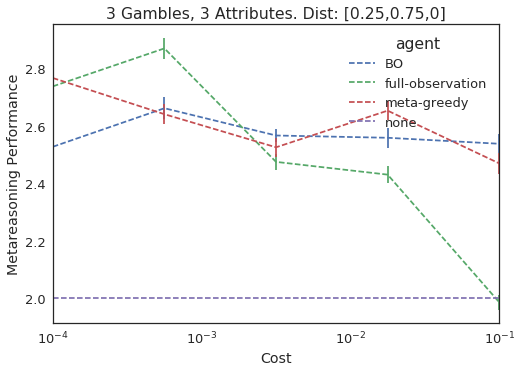

In [56]:
error = df.groupby('cost agent'.split()).util.std().unstack()*1.96/np.sqrt(1000)
(df
 .groupby('cost agent'.split())
 .util.mean().unstack()
 .plot(logx=True, ls='--',yerr=error, by='n_arm'))
# plt.xlim(10**-4.05,10**-0.95)
plt.ylabel('Metareasoning Performance')
plt.xlabel('Cost')
plt.title('3 Gambles, 3 Attributes. Dist: [0.25,0.75,0]')

In [58]:
data = Parallel(n_jobs=20)(delayed(run_params)(cost=cost) for cost in np.logspace(-4, -1, 5))
store = pd.HDFStore('second_try.h5')
store['data'] = pd.concat(data)
store.close()

3 gambles, probs: [0.25, 0.74, 0.01], cost:0.0001
3 gambles, probs: [0.25, 0.74, 0.01], cost:0.00056234132519
3 gambles, probs: [0.25, 0.74, 0.01], cost:0.00316227766017
3 gambles, probs: [0.25, 0.74, 0.01], cost:0.0177827941004
3 gambles, probs: [0.25, 0.74, 0.01], cost:0.1
BO: [ 4.071  0.339  0.133  0.528  1.   ] -> 2.241 in 397 sec
BO: [ 7.28   0.222  0.532  0.246  1.   ] -> 2.577 in 800 sec
BO: [ 19.083   0.52    0.403   0.077   1.   ] -> 2.801 in 1044 sec
BO: [ 12.391   0.459   0.185   0.356   1.   ] -> 2.728 in 1183 sec
BO: [ 14.735   0.4     0.26    0.339   1.   ] -> 2.793 in 1406 sec


/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


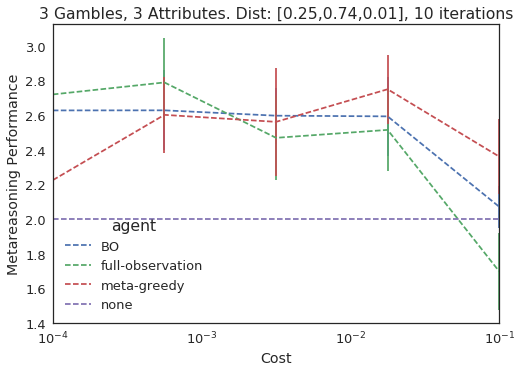

In [65]:
# df = pd.concat(data)
df = pd.read_hdf('second_try.h5','data')
error = df.groupby('cost agent'.split()).util.std().unstack()*1.96/np.sqrt(20)
(df
 .groupby('cost agent'.split())
 .util.mean().unstack()
 .plot(logx=True, ls='--',yerr=error, by='n_arm'))
# plt.xlim(10**-4.05,10**-0.95)
plt.ylabel('Metareasoning Performance')
plt.xlabel('Cost')
plt.title('3 Gambles, 3 Attributes. Dist: [0.25,0.74,0.01], 10 iterations')

## Unit Testing for Mouselab Environment

In [168]:
gambles = 4
attributes = [0.25,0.75,0,0]
reward = Normal(2,1)
env = OldMouselabEnv(gambles, attributes,reward)
env.reset()

array([Norm(2.00, 1.00), Norm(2.00, 1.00), Norm(2.00, 1.00), Norm(2.00, 1.00), Norm(2.00, 1.00), Norm(2.00, 1.00), Norm(2.00, 1.00), Norm(2.00, 1.00), Norm(2.00, 1.00), Norm(2.00, 1.00),
       Norm(2.00, 1.00), Norm(2.00, 1.00), Norm(2.00, 1.00), Norm(2.00, 1.00), Norm(2.00, 1.00), Norm(2.00, 1.00)], dtype=object)

In [169]:
env.vars

array([ 0.625,  0.625,  0.625,  0.625])

In [170]:
env.mus

[2.0, 2.0, 2.0, 2.0]

In [171]:
env.step(1)
env.step(5)
env.step(4)
env.step(4)

step 1
obs 1
step 5
obs 5
step 4
obs 4
step 4


((Norm(2.00, 1.00),
  1.0387309172247476,
  Norm(2.00, 1.00),
  Norm(2.00, 1.00),
  1.925737927437906,
  1.2992395552812623,
  Norm(2.00, 1.00),
  Norm(2.00, 1.00),
  Norm(2.00, 1.00),
  Norm(2.00, 1.00),
  Norm(2.00, 1.00),
  Norm(2.00, 1.00),
  Norm(2.00, 1.00),
  Norm(2.00, 1.00),
  Norm(2.00, 1.00),
  Norm(2.00, 1.00)),
 0,
 False,
 {})

In [172]:
env.vpi()

[Norm(1.28, 0.06) Norm(1.46, 0.00) Norm(2.00, 0.57) Norm(2.00, 0.57)]


0.32968609849781005

In [173]:
env.expected_term_reward()

bg [Norm(0.50, 0.06) Norm(1.50, 0.56) Norm(0.00, 0.00) Norm(0.00, 0.00)]


2.0

In [174]:
np.max(env.mus)

2.0

In [175]:
grid = np.array(env._state).reshape(env.gambles,env.outcomes)
print(grid)
print(env.mus)
print(env.vars)

[[Norm(2.00, 1.00) 1.0387309172247476 Norm(2.00, 1.00) Norm(2.00, 1.00)]
 [1.925737927437906 1.2992395552812623 Norm(2.00, 1.00) Norm(2.00, 1.00)]
 [Norm(2.00, 1.00) Norm(2.00, 1.00) Norm(2.00, 1.00) Norm(2.00, 1.00)]
 [Norm(2.00, 1.00) Norm(2.00, 1.00) Norm(2.00, 1.00) Norm(2.00, 1.00)]]
[1.2790481879185607, 1.4558641483204231, 2.0, 2.0]
[ 0.062  0.     0.625  0.625]


In [176]:
env.dist

array([ 0.25,  0.75,  0.  ,  0.  ])

In [177]:
grid

array([[Norm(2.00, 1.00), 1.0387309172247476, Norm(2.00, 1.00), Norm(2.00, 1.00)],
       [1.925737927437906, 1.2992395552812623, Norm(2.00, 1.00), Norm(2.00, 1.00)],
       [Norm(2.00, 1.00), Norm(2.00, 1.00), Norm(2.00, 1.00), Norm(2.00, 1.00)],
       [Norm(2.00, 1.00), Norm(2.00, 1.00), Norm(2.00, 1.00), Norm(2.00, 1.00)]], dtype=object)

In [178]:
np.sum(grid[1] * env.dist)

Norm(1.46, 0.00)

In [179]:
gambles = grid.dot(env.dist)
samples_max = np.amax([[gambles[i].sample() for i in range(env.gambles)] for _ in range(2500)],1)

In [180]:
gambles

array([Norm(1.28, 0.06), Norm(1.46, 0.00), Norm(2.00, 0.57), Norm(2.00, 0.57)], dtype=object)

In [181]:
env.gambles

4

In [182]:
import datetime

In [183]:
a = datetime.datetime.now()
means = []
for i in range(100):
    samples = [np.max([gambles[i].sample() for i in range(env.gambles)]) for i in range(2500)]
    means.append(np.mean(samples))
t = datetime.datetime.now() - a
print(np.mean(means))

2.32407956312


In [184]:
print(t)

0:00:05.027743


In [185]:
a = datetime.datetime.now()
means = []
for i in range(100):
    samples = np.amax([[gambles[i].sample() for i in range(env.gambles)] for _ in range(2500)],1)
    means.append(np.mean(samples))
t = datetime.datetime.now() - a
print(np.mean(means))

2.32389103332


In [186]:
print(t)

0:00:01.232662


In [187]:
gambles[1].sample()

1.4558641483204233

In [188]:
env.dist * grid[1]

array([0.4814344818594765, 0.9744296664609468, Norm(0.00, 0.00), Norm(0.00, 0.00)], dtype=object)

In [189]:
env.reset()
grid = np.array(env._state).reshape(env.gambles,env.outcomes)
env.dist * grid[1]

array([Norm(0.50, 0.06), Norm(1.50, 0.56), Norm(0.00, 0.00), Norm(0.00, 0.00)], dtype=object)

In [190]:
[expectation(np.sum(env.dist*grid[g])) for g in range(env.gambles)]

[2.0, 2.0, 2.0, 2.0]

In [191]:
best_gamble = env.best_gamble()

In [192]:
best_gamble[3]

Norm(2.00, 1.00)

In [193]:
np.sum(best_gamble).sample()

9.594203092044886

In [194]:
env.dist*grid[1]

array([Norm(0.50, 0.06), Norm(1.50, 0.56), Norm(0.00, 0.00), Norm(0.00, 0.00)], dtype=object)

In [195]:
env.expected_term_reward()

bg [Norm(0.50, 0.06) Norm(1.50, 0.56) Norm(0.00, 0.00) Norm(0.00, 0.00)]


2.0

## Training Trials

In [210]:
gambles = 4
attributes = [0.25,0.75,0,0]
reward = Normal(2,1)
env = OldMouselabEnv(gambles, attributes,reward)

In [211]:
len(env._state)

16

In [212]:
pol = LiederPolicy([1, 1, 0, 0, 1])

In [213]:
len(list(env.actions()))

17

In [214]:
env

In [215]:
agent = Agent()
def run_env(policy, env):
    agent.register(env)
    agent.register(policy)
    tr = agent.run_episode()
    return {'util': tr['return'],
            'observations': len(tr['actions']) - 1}
run_env(pol, env) 

/global/software/sl-6.x86_64/modules/langs/python/3.5.1/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1645: RuntimeWarning: divide by zero encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/global/software/sl-6.x86_64/modules/langs/python/3.5.1/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/global/software/sl-6.x86_64/modules/langs/python/3.5.1/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1728: RuntimeWarning: divide by zero encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)


{'observations': 16, 'util': 3.225274770852804}

In [216]:
def run_params(gambles = 3, attributes = [0.25,0.75,0], reward = Normal(2,1), max_obs=30, cost=.01):
    print(str(gambles)+' gambles, probs: '+ str(attributes) + ', cost:' + str(cost))
    env = OldMouselabEnv(gambles, attributes,reward)
    train_envs = [env] * 1
    term_action = train_envs[0].term_action
    policies = {
#         'BO': bo_policy(train_envs, max_cost=30, n_jobs=5, n_calls=250, 
#                         verbose=0, normalize_voi=False),
#         'BO': bo_policy(train_envs, max_cost=max_obs, n_calls=150),
#         'BO_unnorm': bo_policy(train_envs, max_cost=max_obs, normalize_voi=False, n_calls=350),
        'meta-greedy': LiederPolicy([1, 1, 0, 0, 1]),
#         'blinkered': blinkered_policy(env),
#         'optimal': optimal_policy(env),
        'full-observation': LiederPolicy([-100, 0.5, 0.5, 0, 1]),
        'none': FixedPlanPolicy([term_action])
    }
    test_envs = [env] * 20
    def test():    
        for name, policy in policies.items()
            df = evaluate(policy, envs=test_envs)
            df['agent'] = name
            df['gambles'] = gambles
            df['attr'] = str(attributes)
            df['cost'] = cost
            yield df
    return pd.concat(test())

In [219]:
data = Parallel(n_jobs=7)(delayed(run_params)(cost=cost) for cost in np.logspace(-4, -1, 7))
store = pd.HDFStore('first_try.h5')
store['data'] = pd.concat(data)
store.close()

3 gambles. probs: [0.25, 0.75, 0]
3 gambles. probs: [0.25, 0.75, 0]
3 gambles. probs: [0.25, 0.75, 0]
3 gambles. probs: [0.25, 0.75, 0]
3 gambles. probs: [0.25, 0.75, 0]
3 gambles. probs: [0.25, 0.75, 0]
3 gambles. probs: [0.25, 0.75, 0]


/global/software/sl-6.x86_64/modules/langs/python/3.5.1/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1645: RuntimeWarning: divide by zero encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/global/software/sl-6.x86_64/modules/langs/python/3.5.1/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1645: RuntimeWarning: divide by zero encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/global/software/sl-6.x86_64/modules/langs/python/3.5.1/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1645: RuntimeWarning: divide by zero encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/global/software/sl-6.x86_64/modules/langs/python/3.5.1/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn

KeyboardInterrupt: 